In [1]:
import json
from impresso_commons.path.path_s3 import IMPRESSO_STORAGEOPT
from impresso_images.data_utils import fixed_s3fs_glob
from dask import bag as db
# from tabulate import tabulate
#import matplotlib
#from matplotlib import pyplot as plt

In [2]:
import os
from dask_k8 import DaskCluster
from dask import bag as db
from impresso_commons.path.path_s3 import read_s3_issues
from impresso_commons.text.rebuilder import rebuild_issues, compress, upload, cleanup

In [3]:
import dask

In [4]:
dask.__version__

'1.1.5'

## Set up dask kubernetes cluster

In [6]:
kube_cfg = """
  containers:
    - image: daskdev/dask:1.1.5
      args: [dask-worker, $(DASK_SCHEDULER_ADDRESS), --nthreads, '1', --no-bokeh, --memory-limit, 20GB, --death-timeout, '120']
      imagePullPolicy: Always
      name: dask-worker
      env:
        - name: POD_IP
          valueFrom:
            fieldRef:
              fieldPath: status.podIP
        - name: POD_NAME
          valueFrom:
            fieldRef:
              fieldPath: metadata.name
        - name: EXTRA_PIP_PACKAGES
          value: https://github.com/impresso/impresso-pycommons/archive/master.zip
        - name: EXTRA_CONDA_PACKAGES
          value:
        - name: SE_ACCESS_KEY
          value: {}
        - name: SE_SECRET_KEY
          value: {}
      resources:
        requests:
          cpu: 1
          memory: "20G"
        limits:
          cpu: 1
          memory: "20G"
      volumeMounts:
        - mountPath: /scratch
          name: scratch
          subPath: romanell
  volumes:
    - name: scratch
      persistentVolumeClaim:
        claimName: dhlab-scratch
""".format(
    os.environ["SE_ACCESS_KEY"],
    os.environ["SE_SECRET_KEY"]
)

In [7]:
cluster = DaskCluster(namespace="dhlab", cluster_id="matteo-dask", worker_pod_spec=kube_cfg)

In [8]:
cluster.create()

Scheduler: tcp://10.90.47.27:9752
Dashboard: http://10.90.47.27:12262


In [8]:
cluster.close()

In [9]:
cluster.scale(50, blocking=False)

In [11]:
dask_client = cluster.make_dask_client()

Could not connect to scheduler, retrying...
Could not connect to scheduler, retrying...


In [12]:
dask_client

Client Scheduler: tcp://10.90.47.11:24379 Dashboard: http://10.90.47.11:8787/status,Cluster Workers: 7 Cores: 7 Memory: 140.00 GB


## Process named entity mentions

In [13]:
files = []

nps = ['GDL']

for np in nps:
    files += fixed_s3fs_glob(f"s3://processed-canonical-data/ne_mentions/{np}/18*.jsonl.bz2")

In [14]:
len(files)

10

In [15]:
bag = db.read_text(
    files,
    storage_options=IMPRESSO_STORAGEOPT
).map(json.loads).persist()

In [65]:
mentions_df.head()

,id,nes,s3v,sys_id,ts
0,GDL-1805-02-01-a-i0003,"[{'type': 'Location', 'subType': 'countryName'...",null,rb,2019-01-24T16:09:24Z
1,GDL-1888-06-19-a-i0004,"[{'type': 'Person', 'surface': 'Gazelle de Lau...",null,rb,2019-01-24T17:42:55Z
2,GDL-1970-06-10-a-i0214,"[{'type': 'Location', 'subType': 'countryName'...",null,rb,2019-01-24T21:01:30Z
3,GDL-1980-06-23-a-i0052,"[{'type': 'Location', 'subType': 'adminUnit', ...",null,rb,2019-01-24T21:46:15Z
4,GDL-1984-01-27-a-i0157,"[{'type': 'Location', 'subType': 'countryName'...",null,rb,2019-01-24T22:07:44Z


In [16]:
bag.count().compute()

42763

In [20]:
bag.take(1)

({'id': 'GDL-1809-06-02-a-i0002',
  's3v': 'null',
  'ts': '2019-01-24T16:14:04Z',
  'sys_id': 'rb',
  'nes': [{'type': 'Location',
    'subType': 'provinceCapital',
    'surface': 'Schwarzenberg',
    'name': 'Schwarzenberg',
    'lOffset': 49,
    'rOffset': 62},
   {'type': 'Location',
    'subType': 'countryName',
    'surface': 'Autriche',
    'name': 'Autriche',
    'lOffset': 78,
    'rOffset': 86},
   {'type': 'Location',
    'subType': 'countryName',
    'surface': 'Suède',
    'name': 'Suède',
    'lOffset': 126,
    'rOffset': 131},
   {'type': 'Location',
    'subType': 'countryName',
    'surface': 'Suède',
    'name': 'Suède',
    'lOffset': 246,
    'rOffset': 251},
   {'type': 'Location',
    'subType': 'adminUnit',
    'surface': 'France',
    'name': 'France',
    'lOffset': 293,
    'rOffset': 299},
   {'type': 'Location',
    'subType': 'countryName',
    'surface': 'Russie',
    'name': 'Russie',
    'lOffset': 306,
    'rOffset': 312},
   {'type': 'Location',
    

In [17]:
grouped_mentions = bag.groupby(lambda r: f"{r['id'].split('-')[0]}-{r['id'].split('-')[1]}")

In [59]:
np = 'GDL'
year = 1888
rebuilt_path = f"s3://canonical-rebuilt/{np}/{np}-{year}.jsonl.bz2"
rebuilt_data = db.read_text(
    rebuilt_path,
    storage_options=IMPRESSO_STORAGEOPT
).map(json.loads).persist()

In [60]:
joined_bag = bag.join(rebuilt_data, lambda x: x['id'], lambda y: y['id']).persist()

In [61]:
w = joined_bag.map(lambda x: (x[1]['nes'], x[0]['ft'])).compute()

In [63]:
w[1]

([{'type': 'Location',
   'subType': 'provinceCapital',
   'surface': 'CANTON',
   'name': 'CANTON',
   'lOffset': 0,
   'rOffset': 6},
  {'type': 'Location',
   'subType': 'provinceCapital',
   'surface': 'Vevey',
   'name': 'Vevey',
   'lOffset': 173,
   'rOffset': 178},
  {'type': 'Location',
   'subType': 'adminUnit',
   'surface': 'MONTREUX',
   'name': 'MONTREUX',
   'lOffset': 247,
   'rOffset': 255},
  {'type': 'Location',
   'subType': 'adminUnit',
   'surface': 'Montreux',
   'name': 'Montreux',
   'lOffset': 309,
   'rOffset': 317},
  {'type': 'Person',
   'surface': 'M. Louis Favez',
   'name': 'Louis Favez',
   'firstname': 'Louis',
   'surname': 'Favez',
   'lOffset': 488,
   'rOffset': 502,
   'title': 'M.',
   'mrule': 'person2_title_pre_4_stw_passed',
   'confidence': 'low'},
  {'type': 'Person',
   'surface': 'M. Herzog',
   'name': 'M. Herzog',
   'firstname': 'M.',
   'surname': 'Herzog',
   'lOffset': 547,
   'rOffset': 556,
   'mrule': 'person1_basic_initials_1_pa

### try join between dataframes

Merging between dataframes is more performant than between bags.

In [76]:
mentions_df = db.read_text(
    files,
    storage_options=IMPRESSO_STORAGEOPT
).map(json.loads).to_dataframe().set_index('id')

In [78]:
mentions_df.index

Dask Index Structure:
npartitions=10
GDL-1798-02-01-a-i0001    object
GDL-1887-05-13-a-i0020       ...
                           ...  
GDL-1992-05-26-a-i0218       ...
GDL-1997-12-31-a-i0031       ...
Name: id, dtype: object
Dask Name: sort_index, 230 tasks

In [79]:
rebuilt_path = f"s3://canonical-rebuilt/{np}/{np}-18*.jsonl.bz2"
rebuilt_df = db.read_text(
    rebuilt_path,
    storage_options=IMPRESSO_STORAGEOPT
).map(json.loads).persist().to_dataframe().set_index('id')

In [80]:
rebuilt_df.index

Dask Index Structure:
npartitions=96
GDL-1804-01-03-a-i0001    object
GDL-1805-01-01-a-i0001       ...
                           ...  
GDL-1899-01-03-a-i0001       ...
GDL-1899-12-30-a-i0085       ...
Name: id, dtype: object
Dask Name: sort_index, 480 tasks

In [83]:
merged_dfs = mentions_df.merge(rebuilt_df, left_index=True, right_index=True)

In [130]:
merged_bag = merged_dfs[['ft', 'nes', 'sys_id']].to_bag(index=True).persist()

In [158]:
def prepare_input(ci_id, fulltext, mentions, system_id):
    start = 0
    prepared_input = ""
    for mention in mentions:
        prepared_input += fulltext[start:mention['lOffset']]
        prepared_input += f"[[{fulltext[mention['lOffset']:mention['rOffset']]}]]"
        start = mention['rOffset']
    return {
        "id": ci_id,
        "ft": fulltext,
        "input": prepared_input,
        "nes": mentions,
        "sys_id": system_id
    }
        

In [163]:
prepared_input = merged_bag.starmap(prepare_input).persist()

## try disambiguating

**NB**: `findExtractedMentions()` doesn't seem to work when the character preceding a mention is an apostrophe (e.g. l'[[Egypte]]).

In [170]:
from py4j.java_gateway import JavaGateway
gateway = JavaGateway()

aida_server = gateway.entry_point.getAida()

In [214]:
x = prepared_input.take(21, npartitions=100)[-1]

In [215]:
test_sentence = x['input']

In [216]:
x['input']

"RÉPUBLIQUE [[SUISSE]]. De St. Gall, le 28 juillet. L'on recommence de nouveau, d'après le système ifincamération trichienne-, à procéder contre toutes les propriétés helvétiques situées de l'autre côté du Rhin, & déjà les possessions des communes du Rheinthal, qui sont d'une valeur très-considérable, viennent d'être séquestrées. De Berne, le 29 juillet. Parmi le grand nombre de voyageurs de marque qui ont passé ici, l'on distingue le général Sebastiani, connu par son rapport sur l'[[Egypte]]. Il n'a fait qu'un très-petit séjour dans notre ville, qu'il a en majeure partie . passé chez son excellence le ministre français. Il y a eu en outre plusieurs suédois, danois & allemands, qui tous sont allés voir l'institut de Pestalozzi, à Bouchsée. — Dans la séance de la diète du 14, à l'occasion de la discussion sur les troubles du canton de [[Zurich]], la proposition de faire une loi organique en explication du 20. art. de fafte de médiation, a été mise à l'ordre du jour. Cet article est de l

In [217]:
mentions = gateway.entry_point.findExtractedMentions(test_sentence)
annotations = aida_server.disambiguate(test_sentence, mentions, "fullSettings")

In [218]:
for mention in annotations.keySet():
    wikipedia_entity_id = f"http://en.wikipedia.org/wiki/{annotations.get(mention).getName()}"
    print(mention.getMention(), wikipedia_entity_id)

Zurich http://en.wikipedia.org/wiki/Zürich
SUISSE http://en.wikipedia.org/wiki/Suisse,_Moselle
Fribourg http://en.wikipedia.org/wiki/Fribourg


In [166]:
prepared_input.count().compute()

4990

In [220]:
cluster.close()

## Olf stuff

In [214]:
data = bag.pluck('i')\
    .flatten()\
    .map(lambda x: {
        'id': x['m']['id'],
        'lang': x['m']['l'] if 'l' in x['m'] else None,
        'type': x['m']['tp'],
        'year': int(x['m']['id'].split('-')[1]),
        'newspaper': x['m']['id'].split('-')[0]
    })\
    .persist()

In [215]:
df = data.to_dataframe()

In [216]:
future, n_col = df.shape

In [217]:
future.compute()

2088386

In [218]:
print(tabulate(
        df.groupby('newspaper')[['id']].count().compute(),
        tablefmt='github',
        headers=['newspaper', 'content item count']
))

| newspaper   |   content item count |
|-------------|----------------------|
| luxwort     |          1.19195e+06 |
| indeplux    |     764854           |
| armeteufel  |      20968           |
| courriergdl |      76922           |
| diekwochen  |       8239           |
| luxzeit1858 |      14216           |
| onsjongen   |      11233           |


In [222]:
print(tabulate(
        df.groupby(['newspaper', 'lang'])[['type']].count().compute(),
        tablefmt='github',
))

|-----------------------|--------|
| ('luxwort', 'fr')     |  28279 |
| ('luxwort', 'de')     | 631154 |
| ('luxwort', 'nl')     |     16 |
| ('luxwort', 'fi')     |      7 |
| ('luxwort', 'da')     |      2 |
| ('luxwort', 'pt')     |      1 |
| ('luxwort', 'lb')     |    415 |
| ('luxwort', 'en')     |     39 |
| ('indeplux', 'de')    |   9145 |
| ('indeplux', 'fr')    | 566572 |
| ('armeteufel', 'de')  |  13637 |
| ('armeteufel', 'fr')  |      1 |
| ('courriergdl', 'de') |   2437 |
| ('courriergdl', 'fr') |  48450 |
| ('diekwochen', 'de')  |   6864 |
| ('diekwochen', 'fr')  |    228 |
| ('diekwochen', 'lb')  |    137 |
| ('luxzeit1858', 'de') |   3620 |
| ('luxzeit1858', 'fr') |   5313 |
| ('luxzeit1858', 'lb') |    328 |
| ('onsjongen', 'de')   |   2534 |
| ('onsjongen', 'fr')   |    719 |
| ('onsjongen', 'lb')   |   1298 |
| ('onsjongen', 'en')   |      2 |


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client -

In [147]:
print(tabulate(
        df.groupby('type')[['type']].count().compute(),
        tablefmt='github',
        headers=['content item type','count']
))

| content item type   |           count |
|---------------------|-----------------|
| ad                  | 598016          |
| article             |      1.3212e+06 |
| death_notice        |  88925          |
| table               |  43221          |
| image               |  35266          |
| weather             |   1760          |


In [192]:
np_by_year = df.groupby('year')[['year']].count().compute()

<BarContainer object of 111 artists>

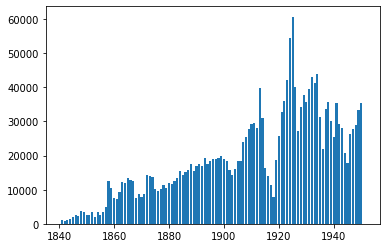

In [204]:
plt.bar(np_by_year.index, np_by_year.year)